In [1]:
!python /content/drive/MyDrive/Master_thesis/GP-MVS/test.py /content/drive/MyDrive/Master_thesis/seq-01_formatted/ --savepath /content/drive/MyDrive/Master_thesis/test_result/disparity.npy --encoder /content/drive/MyDrive/Master_thesis/gpmvs_tmp/encoder/encoder_model_best.pth.tar --gp /content/drive/MyDrive/Master_thesis/gpmvs_tmp/gplayer/gp_model_best.pth.tar --decoder /content/drive/MyDrive/Master_thesis/gpmvs_tmp/decoder/decoder_model_best.pth.tar

Traceback (most recent call last):
  File "/content/drive/MyDrive/Master_thesis/GP-MVS/test.py", line 4, in <module>
    from path import Path
ModuleNotFoundError: No module named 'path'


In [2]:
!pwd

/content


In [3]:
import sys
import os

py_file_location = "/content/drive/MyDrive/Master_thesis/GP-MVS/"
sys.path.append(os.path.abspath(py_file_location))


In [4]:
!pip install path

In [14]:
!pwd

/content


In [15]:
import argparse

import numpy as np
from path import Path
import pylab as plt

import cv2

from numpy.linalg import inv
from tqdm import tqdm
import pickle

import os

import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch import Tensor

from enCoder import enCoder
from deCoder import deCoder
from GPlayer import GPlayer

In [16]:
seqpath = "/content/drive/MyDrive/Master_thesis/seq-01_formatted/"
savepath = "/content/drive/MyDrive/Master_thesis/test_result/disparity.npy"
encoder = "/content/drive/MyDrive/Master_thesis/gpmvs_tmp/encoder/encoder_model_best.pth.tar"
gp = "/content/drive/MyDrive/Master_thesis/gpmvs_tmp/gplayer/gp_model_best.pth.tar"
decoder = "/content/drive/MyDrive/Master_thesis/gpmvs_tmp/decoder/decoder_model_best.pth.tar"


In [17]:
def pose_distance(p1, p2):
    rel_pose = np.dot(p1, inv(p2))
    R = rel_pose[:3, :3]
    t = rel_pose[:3, 3]

    return round(np.sqrt(np.linalg.norm(t) ** 2 + 2 * (1 - min(3.0, np.matrix.trace(R)) / 3)), 4)

In [18]:
# 
def genDistM(poses):
    n = len(poses)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = pose_distance(poses[i], poses[j])
    return D


In [19]:
def compute_errors(gt, pred):
    valid1 = gt > 0.5
    valid2 = gt < 50
    valid = valid1 & valid2

    gt = gt[valid]
    pred = 1 / pred[valid]

    L1 = np.mean(np.abs(gt - pred))
    L1_rel = np.mean(np.abs(gt - pred) / gt)
    L1_inv = np.mean(np.abs(1 / gt - 1 / pred))

    log_diff = np.log(gt) - np.log(pred)
    sc_inv = np.sqrt(np.mean(np.square(log_diff)) - np.square(np.mean(log_diff)))

    return L1, L1_rel, L1_inv, sc_inv

In [20]:
def encoder_forward(r_img,n_img, r_pose,n_pose, K):

    left_image = r_img
    right_image = n_img


    left_pose = r_pose
    right_pose = n_pose

    camera_k = K


    left2right = np.dot(right_pose, inv(left_pose))

    # scale to 320x256
    original_width = left_image.shape[1]
    original_height = left_image.shape[0]
    factor_x = 320.0 / original_width
    factor_y = 256.0 / original_height

    left_image = cv2.resize(left_image, (320, 256))
    right_image = cv2.resize(right_image, (320, 256))
    camera_k[0, :] *= factor_x
    camera_k[1, :] *= factor_y

    # convert to torch
    torch_left_image = np.moveaxis(left_image, -1, 0)
    torch_left_image = np.expand_dims(torch_left_image, 0)

    torch_left_image = (torch_left_image - 81.0)/ 35.0
    torch_right_image = np.moveaxis(right_image, -1, 0)
    torch_right_image = np.expand_dims(torch_right_image, 0)

    torch_right_image = (torch_right_image - 81.0)/ 35.0


    left_image_cuda = Tensor(torch_left_image).cuda()
    left_image_cuda = Variable(left_image_cuda, volatile=True)

    right_image_cuda = Tensor(torch_right_image).cuda()
    right_image_cuda = Variable(right_image_cuda, volatile=True)

    left_in_right_T = left2right[0:3, 3]
    left_in_right_R = left2right[0:3, 0:3]
    K = camera_k
    K_inverse = inv(K)
    KRK_i = K.dot(left_in_right_R.dot(K_inverse))
    KRKiUV = KRK_i.dot(pixel_coordinate)
    KT = K.dot(left_in_right_T)
    KT = np.expand_dims(KT, -1)
    KT = np.expand_dims(KT, 0)
    KT = KT.astype(np.float32)
    KRKiUV = KRKiUV.astype(np.float32)
    KRKiUV = np.expand_dims(KRKiUV, 0)
    KRKiUV_cuda_T = Tensor(KRKiUV).cuda()
    KT_cuda_T = Tensor(KT).cuda()

    conv5, conv4, conv3, conv2, conv1= encoder(left_image_cuda, right_image_cuda, KRKiUV_cuda_T,KT_cuda_T)

    return conv5, conv4, conv3, conv2, conv1

In [21]:
# Get the indices matrix refer Testpy_numpy.ipynb
pixel_coordinate = np.indices([320, 256]).astype(np.float32)
# Concatenate the pixel coordinate matrix ([2, 320, 256]) with the ones matrix [1, 320, 256] and the resultant matrix is [3, 320, 256]
pixel_coordinate = np.concatenate(
    (pixel_coordinate, np.ones([1, 320, 256])), axis=0)
# Reshape refer Testpy_numpy.ipynb
pixel_coordinate = np.reshape(pixel_coordinate, [3, -1])

In [22]:
# Load formatted sequence.

# Load the folder containing images, ground truth disparity, Intrinsic parameter and Extrinsic parameter.
scene = Path(seqpath)
# Extract the intrinsic matrix and reshape it to 3,3 matrix
intrinsics = np.loadtxt(scene / 'K.txt').astype(np.float32).reshape((3, 3))
# Extract the images folder and all image of png format
imgs = sorted((scene/'images').files('*.png'))
# Extract the ground truth disparity maps
gts = sorted((scene/'depth').files('*.npy'))

# For storing the camera poses
gt_poses = []

# Get the extrinsic parameters i,e the position of the camera while capturing the images, rotation matrix and translation.
with open(scene / 'poses.txt') as f:
    for l in f.readlines():
        l = l.strip('\n')
        gt_poses.append(np.array(l.split(' ')).astype(np.float32).reshape(4, 4))

In [23]:
#load pre-trained model
# Load the pretrained encoder model
pretrained_encoder = encoder
# Load the pretrained gp player
pretrained_gplayer = gp
# Load the pretrained decoder
pretrained_decoder = decoder

# Transfers a tensor from CPU to GPU 1
encoder = enCoder().cuda()
# Implements data parallelism at the module level.
encoder = torch.nn.DataParallel(encoder)
# Load the pretrained weights
weights = torch.load(pretrained_encoder)
# A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.
encoder.load_state_dict(weights['state_dict'])
encoder.eval()

decoder = deCoder().cuda()
decoder = torch.nn.DataParallel(decoder)
weights = torch.load(pretrained_decoder)
decoder.load_state_dict(weights['state_dict'])
decoder.eval()

gplayer =GPlayer()
weights = torch.load(pretrained_gplayer)
gplayer.load_state_dict(weights['state_dict'])
gplayer.eval()

n = len(imgs)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from torch import Tensor
import cv2
import math
import numpy as np
import time
from numpy.linalg import inv


class GPlayer(nn.Module):


    def __init__(self):
        super(GPlayer, self).__init__()

        self.gamma2 = nn.Parameter(torch.randn(1), requires_grad=True).float()
        self.ell = nn.Parameter(torch.randn(1), requires_grad=True).float()
        self.sigma2 = nn.Parameter(torch.randn(1), requires_grad=True).float()


    def forward(self, D, Y):
        '''
        :param D: Distance matrix
        :param Y: Stacked outputs from encoder
        :return: Z: transformed latent space
        '''
        b,l,c,h,w = Y.size()
        print("----------------")
        print("Y", Y.shape)
        print("b", b)
        print("l", l)
        print("c", c)
        print("h", h)
        print("w", w)
        Y = Y.view(b,l,-1).cpu().float()
        print("D", D.shape)
        D = D.float()
        print("Yup")
        K = torch.exp(self.gamma2) * (1 + math.sqrt(3) * D / torch.exp(self.ell)) * torch.exp(-math.sqrt(3) * D / torch.exp(self.ell))
        print("K", K.shape)
        I = torch.eye(l).expand(b, l, l).float()
        print("I", I.shape)
        X,_ = torch.solve(Y, K+torch.exp(self.sigma2)*I)
        print("X", X.shape)
        Z = K.bmm(X)
        print("Z", Z.shape)
        Z = F.relu(Z)
        print("Z", Z.shape)
        print("----------------")
        return Z

In [25]:
b,l,c,h,w = Y.size()
Y = Y.view(b,l,-1).cpu().float()
D = D.float()
K = torch.exp(self.gamma2) * (1 + math.sqrt(3) * D / torch.exp(self.ell)) * torch.exp(-math.sqrt(3) * D / torch.exp(self.ell))
I = torch.eye(l).expand(b, l, l).float()
X,_ = torch.solve(Y, K+torch.exp(self.sigma2)*I)
Z = K.bmm(X)
Z = F.relu(Z)

NameError: ignored

In [26]:
with torch.no_grad():
    poses = []
    idepths = []
    idepths_after = []
    latents = []
    conv1s = []
    conv2s = []
    conv3s = []
    conv4s = []

    preds = []

    depth_gts = []
    # tqdm is for progress bar
    # Iterate with two images
    for i in tqdm(range(1, n)):  # start with the 2nd frame
        # next image pose
        r_pose = gt_poses[i]
        # current image pose
        n_pose = gt_poses[i - 1]

        # read the next frame image 
        r_img = cv2.imread(imgs[i])
        # read the current frame image
        n_img = cv2.imread(imgs[i - 1])
        # Load the intrinsic camera parameters
        camera_k = np.loadtxt(scene / 'K.txt').astype(np.float32).reshape((3, 3))

        conv5, conv4, conv3, conv2, conv1 = encoder_forward(r_img, n_img, r_pose, n_pose, camera_k)

        poses.append(r_pose)

        latents.append(conv5)
        conv4s.append(conv4)
        conv3s.append(conv3)
        conv2s.append(conv2)
        conv1s.append(conv1)

        gt_depth = np.load(gts[i])
        depth_gts.append(gt_depth)

    with open('/content/drive/MyDrive/Master_thesis/test_result/D.pkl', 'wb') as f:
      pickle.dump(genDistM(poses), f)
    with open('/content/drive/MyDrive/Master_thesis/test_result/Y.pkl', 'wb') as f:
      pickle.dump(latents, f)

    D = torch.from_numpy(np.expand_dims(genDistM(poses), 0))
    Y = torch.stack(latents, dim=1).cpu()

    Z = gplayer(D, Y)

    b, l, c, h, w = Y.size()

    for k in tqdm(range(n - 1)):
        conv5 = Z[:, k].view(b, c, h, w).cuda()
        conv4 = conv4s[k]
        conv3 = conv3s[k]
        conv2 = conv2s[k]
        conv1 = conv1s[k]
        pred = decoder(conv5, conv4, conv3, conv2, conv1)

        idepths.append(pred[0][0].cpu().data.numpy())

    error_names = ['L1', 'L1_rel', 'L1_inv', 'sc_inv']
    errors = np.zeros((1, len(error_names), len(idepths)))

    for i in range(n - 1):
        gt = depth_gts[i]
        h, w = gt.shape

        pred = cv2.resize(idepths[i], (w, h))
        pred = np.clip(pred, a_min=0.02, a_max=2)  # depth range within [0.5, 50]
        preds.append(pred)

        errors[0, :, i] = compute_errors(gt, pred)

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 65/65 [00:50<00:00,  1.29it/s]
/content/drive/MyDrive/Master_thesis/GP-MVS/GPlayer.py:38: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return t

Yup


  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 65/65 [00:07<00:00,  8.29it/s]


# Error Metrics
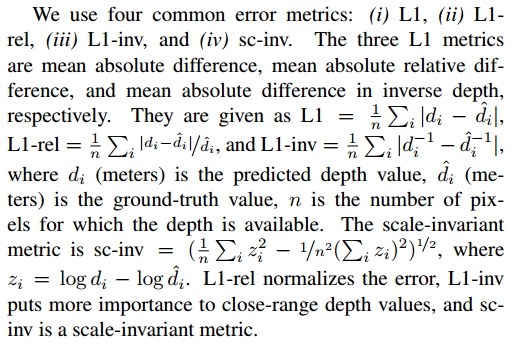

In [27]:
mean_errors = errors.mean(2)
print("Results for original methods : ")
print("{:>10}, {:>10}, {:>10}, {:>10}".format(*error_names))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(*mean_errors[0]))

if savepath is not None:
    np.save(savepath, np.array(preds))

Results for original methods : 
        L1,     L1_rel,     L1_inv,     sc_inv
    0.3447,     0.1795,     0.0900,     0.1545
